# Load packages

In [6]:
import os
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"] = ""
import matplotlib.pyplot as plt
import scanpy as sc
import anndata2ri
import logging
from scipy.sparse import csr_matrix, issparse
import numpy as np
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
import bbknn
import pandas as pd
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import scipy as sp
import scvi
import torch
scvi.settings.seed = 0

#import scarches as sca
rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)



os.chdir('/root/host_home')

Seed set to 0


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# Filenames

In [42]:
#Filename scanpy AnnData input for hp NPC after batch correction
adata_input = 'NPCs_merge/processed_data/NPC_cell_cycle_cuda.h5ad'


#Filename scanpy AnnData output for NPC preprocessing
adata_output = 'NPCs_merge/processed_data/NPC_clustered_scvi_zinb_cuda.h5ad'

In [8]:
lane_key = "lane"
donor_key = 'Donor'
dataset_key = 'cultivation_period'
label_key = "condition"

In [9]:
save_dir = 'NPCs_merge/'

# Read in data

In [6]:
adata = sc.read_h5ad(adata_input)


In [5]:
#adata = sc.read_h5ad(adata_output)

In [10]:
adata

AnnData object with n_obs × n_vars = 61400 × 17366
    obs: 'Donor', 'lane', 'condition', 'age', 'years_of_illness', 'deltaHY', 'deltaUPDRS', 'deltaADL', 'deltaDOPA', 'gender', 'cultivation_period', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'S_score', 'G2M_score', 'phase', 'cell_types', 'cell_types_abbrev', 'size_factors', 'donor_batch_ID', '_scvi_batch', '_scvi_labels', 'Ferroptosis_pos_corr', 'Ferroptosis_neg_corr', 'Apoptosis_pos_corr', 'Apoptosis_neg_corr', 'Necroptosis_pos_corr', 'Autophagy_pos_corr', 'Pathanatos_pos_corr'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_symbols', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_to

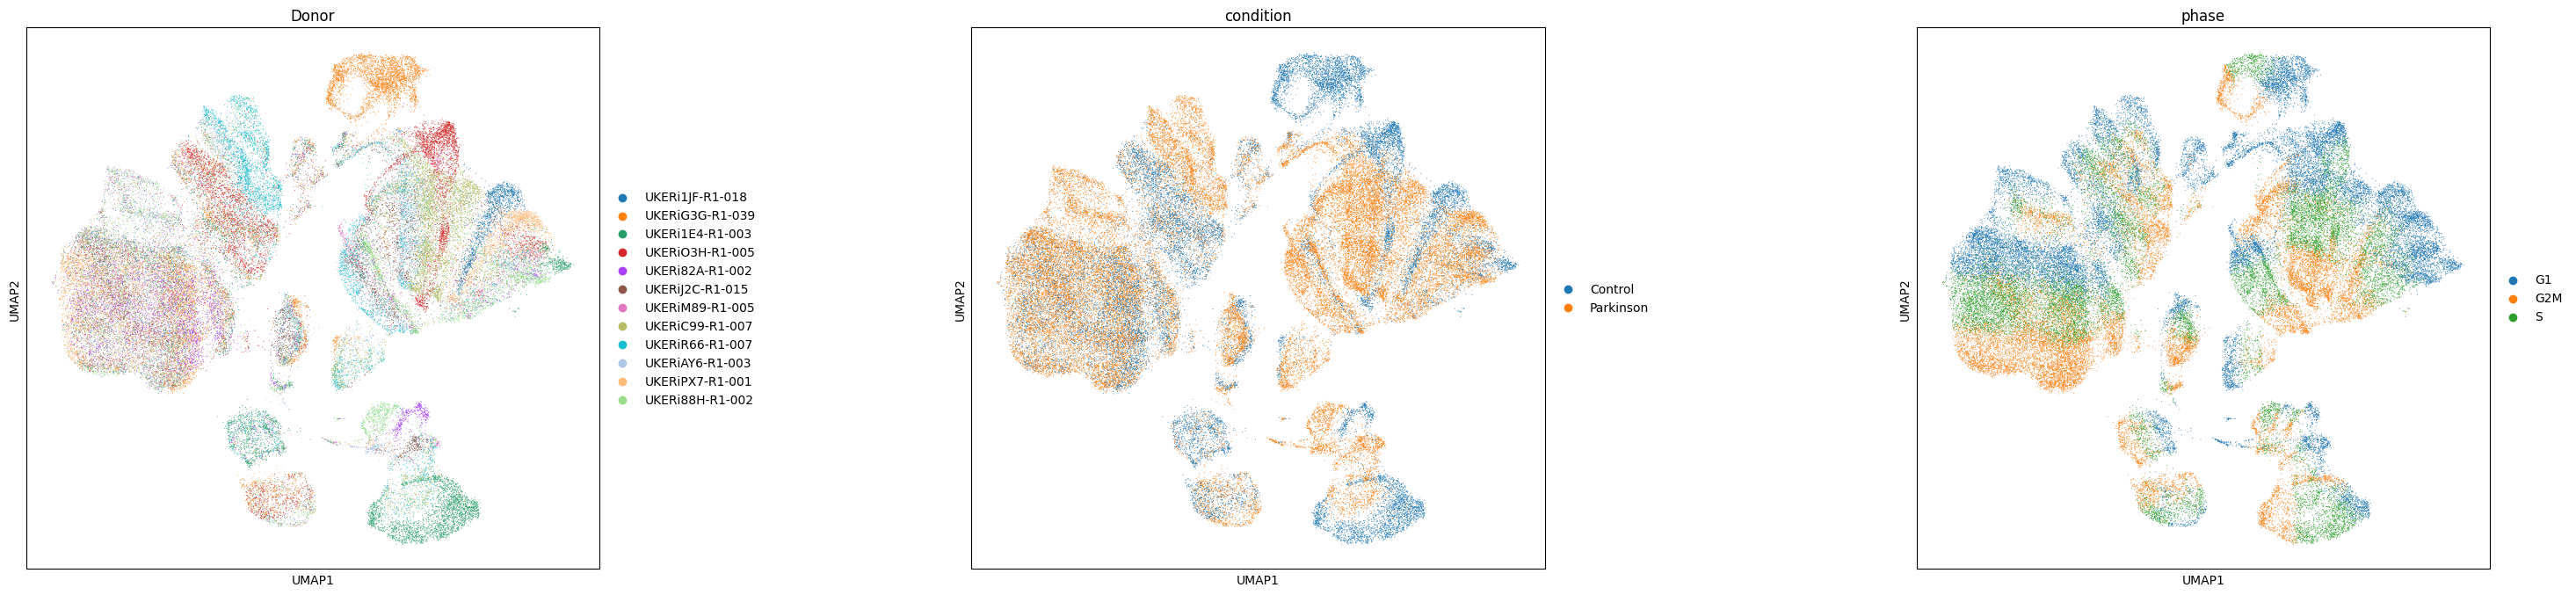

In [9]:
sc.pl.umap(adata, color=[donor_key, label_key, 'phase'], wspace = 0.5)

# Integration

In [11]:
adata.var['highly_variable'] = adata.var['highly_variable_genes_batch_aware']

In [12]:
adata.obs['cell_types'].cat.categories

Index(['Apop. NCSC', 'Apop. NSC', 'Glial precursors', 'Immature neurons',
       'NCSC', 'NSC1a', 'NSC1b', 'NSC2a', 'NSC2b'],
      dtype='object')

In [13]:
#Data preparation
scvi.model.SCVI.setup_anndata(adata, layer="soupX_counts", batch_key=dataset_key, categorical_covariate_keys=[donor_key])
adata

AnnData object with n_obs × n_vars = 61400 × 17366
    obs: 'Donor', 'lane', 'condition', 'age', 'years_of_illness', 'deltaHY', 'deltaUPDRS', 'deltaADL', 'deltaDOPA', 'gender', 'cultivation_period', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'S_score', 'G2M_score', 'phase', 'cell_types', 'cell_types_abbrev', 'size_factors', 'donor_batch_ID', '_scvi_batch', '_scvi_labels', 'Ferroptosis_pos_corr', 'Ferroptosis_neg_corr', 'Apoptosis_pos_corr', 'Apoptosis_neg_corr', 'Necroptosis_pos_corr', 'Autophagy_pos_corr', 'Pathanatos_pos_corr'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_symbols', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_to

In [14]:
#Building the model
model_scvi = scvi.model.SCVI(adata, n_layers=2, n_latent=30)
model_scvi

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 30, n_layers: 2, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

In [15]:
#Print description of the model
model_scvi.view_anndata_setup()

Anndata setup with scvi-tools version 1.1.2.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'soupX_counts',
│   'batch_key': 'cultivation_period',
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': ['Donor'],
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   2   │
│         n_cells          │ 61400 │
│ n_extra_categorical_covs │   1   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 17366 │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │        adata.layers['soupX_counts']        │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                         batch State Registry                         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃         Source Location         ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cultivation_period'] │     lp     │          0          │
│                                 │     hp     │          1          │
└─────────────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

            extra_categorical_covs State Registry             
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃   Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Donor'] │ UKERi1JF-R1-018 │          0          │
│                    │ UKERiG3G-R1-039 │          1          │
│                    │ UKERi1E4-R1-003 │          2          │
│                    │ UKERiO3H-R1-005 │          3          │
│                    │ UKERi82A-R1-002 │          4          │
│                    │ UKERiJ2C-R1-015 │          5          │
│                    │ UKERiM89-R1-005 │          6          │
│                    │ UKERiC99-R1-007 │          7          │
│                    │ UKERiR66-R1-007 │          8          │
│                    │ UKERiAY6-R1-003 │          9          │
│                    │ UKERiPX7-R1-001 │         10          │
│                    │ UKERi88H-R1-002 │         11          │
│                    │                 │                     │
└────────────────────┴─────────────────┴─────────────────────┘

In [16]:
torch.set_float32_matmul_precision('medium')
scvi.settings.dl_num_workers = 15

In [17]:
model_scvi.train(check_val_every_n_epoch=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 130/130: 100%|██████| 130/130 [19:18<00:00,  8.88s/it, v_num=1, train_loss_step=1.06e+4, train_loss_epoch=1.09e+4]

`Trainer.fit` stopped: `max_epochs=130` reached.


Epoch 130/130: 100%|██████| 130/130 [19:18<00:00,  8.91s/it, v_num=1, train_loss_step=1.06e+4, train_loss_epoch=1.09e+4]


In [18]:
#Extract embeddings
adata.obsm["X_scVI_CC"] = model_scvi.get_latent_representation()

In [19]:
#model_scvi.save('NPCs_merge/processed_data/model_scvi_CC_nb_cuda', overwrite=True)

In [20]:
lane_key = "lane"
donor_key = 'Donor'
dataset_key = 'cultivation_period'
label_key = "condition"
cell_type_key = 'cell_types'
unlabeled_category = "unlabeled"

In [21]:
model_scanvi = scvi.model.SCANVI.from_scvi_model(
    model_scvi, labels_key='cell_types', unlabeled_category="unlabelled"
)
print(model_scanvi)
model_scanvi.view_anndata_setup()

ScanVI Model with the following params: 
unlabeled_category: unlabelled, n_hidden: 128, n_latent: 30, n_layers: 2, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb
Training status: Not Trained
Model's adata is minified?: False

Anndata setup with scvi-tools version 1.1.2.

Setup via `SCANVI.setup_anndata` with arguments:

{
│   'labels_key': 'cell_types',
│   'unlabeled_category': 'unlabelled',
│   'layer': 'soupX_counts',
│   'batch_key': 'cultivation_period',
│   'size_factor_key': None,
│   'categorical_covariate_keys': ['Donor'],
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   2   │
│         n_cells          │ 61400 │
│ n_extra_categorical_covs │   1   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │  10   │
│          n_vars          │ 17366 │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │        adata.layers['soupX_counts']        │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                         batch State Registry                         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃         Source Location         ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cultivation_period'] │     lp     │          0          │
│                                 │     hp     │          1          │
└─────────────────────────────────┴────────────┴─────────────────────┘

                       labels State Registry                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location     ┃    Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cell_types'] │    Apop. NCSC    │          0          │
│                         │    Apop. NSC     │          1          │
│                         │ Glial precursors │          2          │
│                         │ Immature neurons │          3          │
│                         │       NCSC       │          4          │
│                         │      NSC1a       │          5          │
│                         │      NSC1b       │          6          │
│                         │      NSC2a       │          7          │
│                         │      NSC2b       │          8          │
│                         │    unlabelled    │          9          │
└─────────────────────────┴──────────────────┴─────────────────────┘

            extra_categorical_covs State Registry             
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃   Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Donor'] │ UKERi1JF-R1-018 │          0          │
│                    │ UKERiG3G-R1-039 │          1          │
│                    │ UKERi1E4-R1-003 │          2          │
│                    │ UKERiO3H-R1-005 │          3          │
│                    │ UKERi82A-R1-002 │          4          │
│                    │ UKERiJ2C-R1-015 │          5          │
│                    │ UKERiM89-R1-005 │          6          │
│                    │ UKERiC99-R1-007 │          7          │
│                    │ UKERiR66-R1-007 │          8          │
│                    │ UKERiAY6-R1-003 │          9          │
│                    │ UKERiPX7-R1-001 │         10          │
│                    │ UKERi88H-R1-002 │         11          │
│                    │                 │                     │
└────────────────────┴─────────────────┴─────────────────────┘

In [22]:

scanvi_epochs = 200

plan_kwargs = {
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}

torch.set_float32_matmul_precision('medium')
scvi.settings.dl_num_workers = 15

In [23]:
model_scanvi.train(
    max_epochs=scanvi_epochs,
    check_val_every_n_epoch=1,
    devices=-1,
    early_stopping = True,
    plan_kwargs = plan_kwargs,
    early_stopping_monitor = 'elbo_validation',
    early_stopping_patience = 10,
    early_stopping_min_delta = 0.0
)


INFO     Training for 200 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_wor

Epoch 200/200: 100%|████| 200/200 [1:10:29<00:00, 21.02s/it, v_num=1, train_loss_step=1.11e+4, train_loss_epoch=1.09e+4]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|████| 200/200 [1:10:29<00:00, 21.15s/it, v_num=1, train_loss_step=1.11e+4, train_loss_epoch=1.09e+4]


Default parameters, except n_latent=30 (higher than default) since we're processing large data with diverse cell types (was also used in benchmarking), and gene_likelihood='nb' instead of zinb since all data are UMI based (hence negative binomially distributed).

In [24]:
adata.obsm["X_scANVI_CC"] = model_scanvi.get_latent_representation()

In [25]:
#Calculate bath-corrected UMAP
sc.pp.neighbors(adata, use_rep="X_scANVI_CC")
sc.tl.umap(adata)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:28)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:31)


In [26]:
adata.uns['neighbors_CC'] = adata.uns['neighbors']
adata.obsp['distances_CC'] = adata.obsp['distances']
adata.obsp['connectivities_CC'] = adata.obsp['connectivities']
adata.obsm['X_umap_CC'] = adata.obsm['X_umap']

In [27]:
#model_scvi.save('NPCs_merge/processed_data/model_scanvi_CC_nb', save_anndata=True)

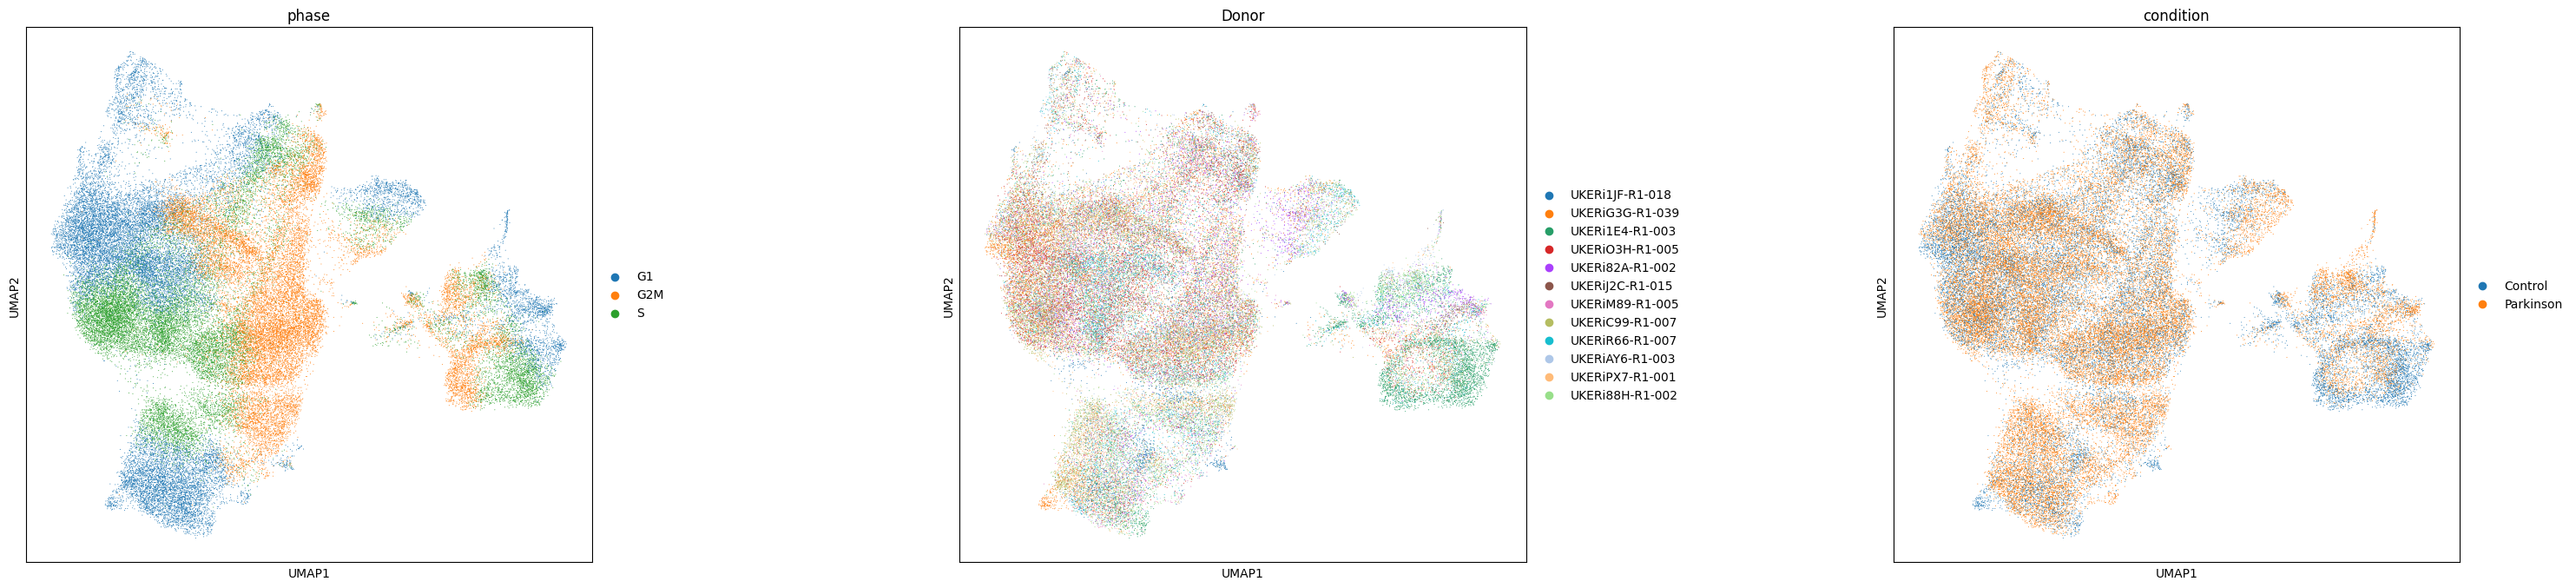

In [28]:
sc.pl.umap(adata, color=['phase', donor_key, label_key], wspace = 0.5)

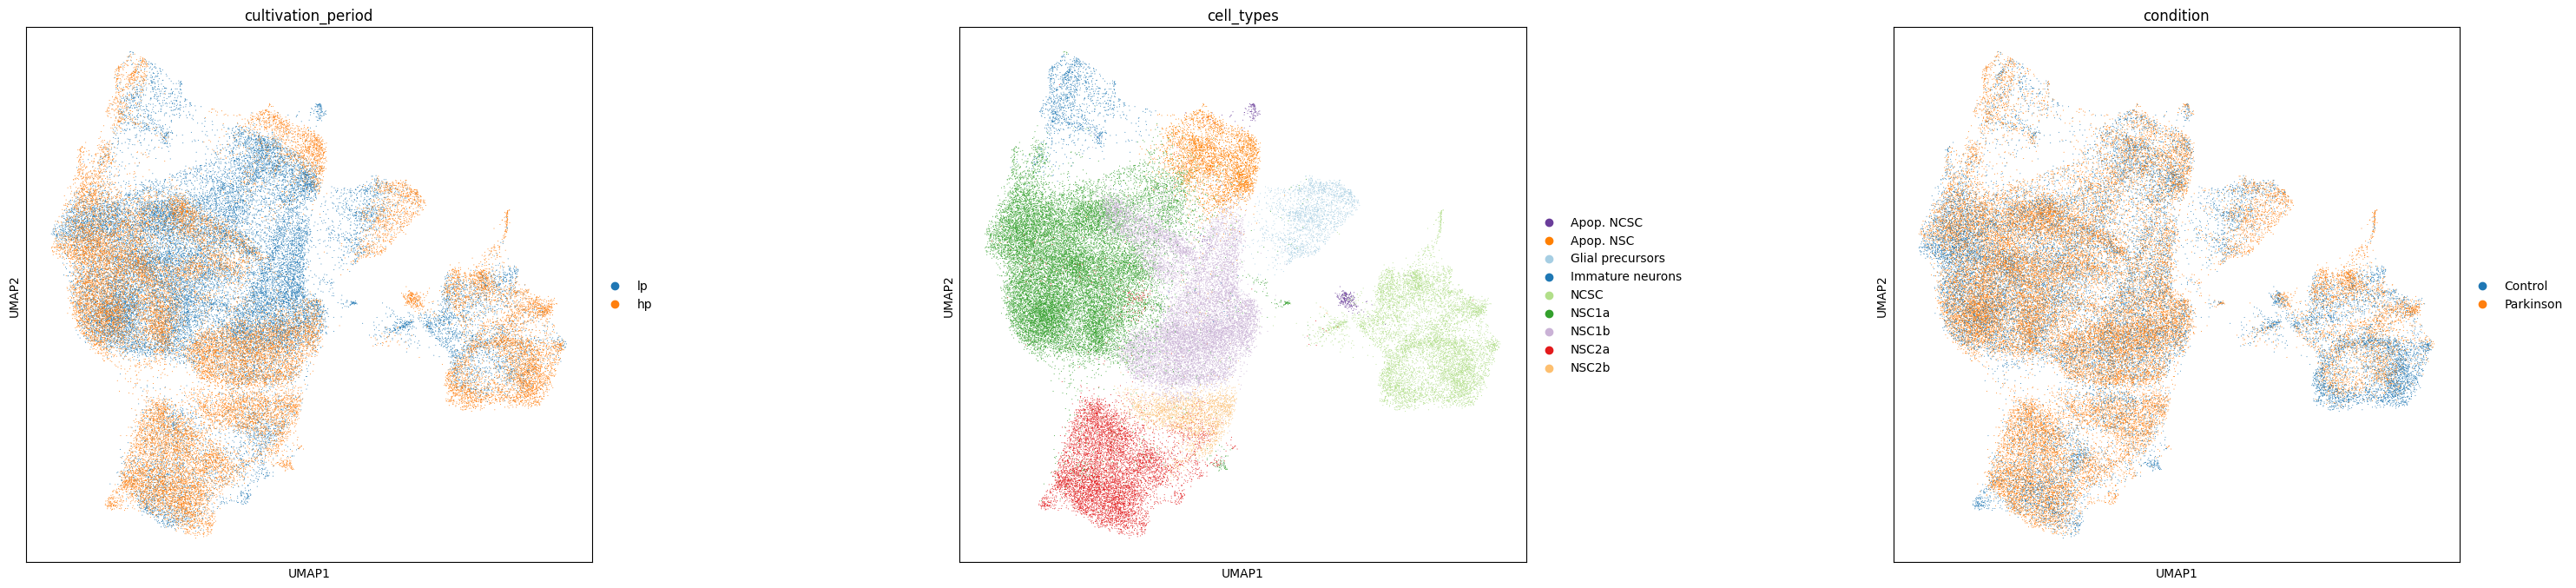

In [29]:
sc.pl.umap(adata, color=['cultivation_period', 'cell_types' , label_key], ncols=3, wspace = 0.5)

In [29]:
adata.write(adata_output)

# Regress out cell cycle

In [30]:
adata

AnnData object with n_obs × n_vars = 61400 × 17366
    obs: 'Donor', 'lane', 'condition', 'age', 'years_of_illness', 'deltaHY', 'deltaUPDRS', 'deltaADL', 'deltaDOPA', 'gender', 'cultivation_period', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'S_score', 'G2M_score', 'phase', 'cell_types', 'cell_types_abbrev', 'size_factors', 'donor_batch_ID', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_symbols', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_genes', 'highly_variable_nbatches', 'highly_variable_intersection', 

In [30]:
#Data preparation
scvi.model.SCVI.setup_anndata(adata, layer="soupX_counts", batch_key=dataset_key, categorical_covariate_keys=[donor_key], continuous_covariate_keys = ['S_score', 'G2M_score'])
adata

AnnData object with n_obs × n_vars = 61400 × 17366
    obs: 'Donor', 'lane', 'condition', 'age', 'years_of_illness', 'deltaHY', 'deltaUPDRS', 'deltaADL', 'deltaDOPA', 'gender', 'cultivation_period', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'S_score', 'G2M_score', 'phase', 'cell_types', 'cell_types_abbrev', 'size_factors', 'donor_batch_ID', '_scvi_batch', '_scvi_labels', 'Ferroptosis_pos_corr', 'Ferroptosis_neg_corr', 'Apoptosis_pos_corr', 'Apoptosis_neg_corr', 'Necroptosis_pos_corr', 'Autophagy_pos_corr', 'Pathanatos_pos_corr'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_symbols', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_to

In [31]:
#Building the model
model_scvi = scvi.model.SCVI(adata, n_layers=2, n_latent=30) # ,  gene_likelihood="nb"
model_scvi

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 30, n_layers: 2, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

In [32]:
#Print description of the model
model_scvi.view_anndata_setup()

Anndata setup with scvi-tools version 1.1.2.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'soupX_counts',
│   'batch_key': 'cultivation_period',
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': ['Donor'],
│   'continuous_covariate_keys': ['S_score', 'G2M_score']
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   2   │
│         n_cells          │ 61400 │
│ n_extra_categorical_covs │   1   │
│ n_extra_continuous_covs  │   2   │
│         n_labels         │   1   │
│          n_vars          │ 17366 │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │        adata.layers['soupX_counts']        │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│ extra_continuous_covs  │ adata.obsm['_scvi_extra_continuous_covs']  │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                         batch State Registry                         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃         Source Location         ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cultivation_period'] │     lp     │          0          │
│                                 │     hp     │          1          │
└─────────────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

            extra_categorical_covs State Registry             
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃   Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Donor'] │ UKERi1JF-R1-018 │          0          │
│                    │ UKERiG3G-R1-039 │          1          │
│                    │ UKERi1E4-R1-003 │          2          │
│                    │ UKERiO3H-R1-005 │          3          │
│                    │ UKERi82A-R1-002 │          4          │
│                    │ UKERiJ2C-R1-015 │          5          │
│                    │ UKERiM89-R1-005 │          6          │
│                    │ UKERiC99-R1-007 │          7          │
│                    │ UKERiR66-R1-007 │          8          │
│                    │ UKERiAY6-R1-003 │          9          │
│                    │ UKERiPX7-R1-001 │         10          │
│                    │ UKERi88H-R1-002 │         11          │
│                    │                 │                     │
└────────────────────┴─────────────────┴─────────────────────┘

  extra_continuous_covs   
      State Registry      
┏━━━━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━┩
│  adata.obs['S_score']  │
│ adata.obs['G2M_score'] │
└────────────────────────┘

In [33]:
model_scvi.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 130/130: 100%|██████| 130/130 [17:43<00:00,  8.19s/it, v_num=1, train_loss_step=1.14e+4, train_loss_epoch=1.09e+4]

`Trainer.fit` stopped: `max_epochs=130` reached.


Epoch 130/130: 100%|██████| 130/130 [17:43<00:00,  8.18s/it, v_num=1, train_loss_step=1.14e+4, train_loss_epoch=1.09e+4]


In [34]:
#Extract embeddings
adata.obsm["X_scVI_noCC"] = model_scvi.get_latent_representation()

In [36]:
#model_scvi.save('NPCs_merge/processed_data/model_scvi_noCC_nb', save_anndata=True)

In [35]:
model_scanvi = scvi.model.SCANVI.from_scvi_model(
    model_scvi, labels_key='cell_types', unlabeled_category="unlabelled"
)
print(model_scanvi)
model_scanvi.view_anndata_setup()

ScanVI Model with the following params: 
unlabeled_category: unlabelled, n_hidden: 128, n_latent: 30, n_layers: 2, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb
Training status: Not Trained
Model's adata is minified?: False

Anndata setup with scvi-tools version 1.1.2.

Setup via `SCANVI.setup_anndata` with arguments:

{
│   'labels_key': 'cell_types',
│   'unlabeled_category': 'unlabelled',
│   'layer': 'soupX_counts',
│   'batch_key': 'cultivation_period',
│   'size_factor_key': None,
│   'categorical_covariate_keys': ['Donor'],
│   'continuous_covariate_keys': ['S_score', 'G2M_score']
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   2   │
│         n_cells          │ 61400 │
│ n_extra_categorical_covs │   1   │
│ n_extra_continuous_covs  │   2   │
│         n_labels         │  10   │
│          n_vars          │ 17366 │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │        adata.layers['soupX_counts']        │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│ extra_continuous_covs  │ adata.obsm['_scvi_extra_continuous_covs']  │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                         batch State Registry                         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃         Source Location         ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cultivation_period'] │     lp     │          0          │
│                                 │     hp     │          1          │
└─────────────────────────────────┴────────────┴─────────────────────┘

                       labels State Registry                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location     ┃    Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cell_types'] │    Apop. NCSC    │          0          │
│                         │    Apop. NSC     │          1          │
│                         │ Glial precursors │          2          │
│                         │ Immature neurons │          3          │
│                         │       NCSC       │          4          │
│                         │      NSC1a       │          5          │
│                         │      NSC1b       │          6          │
│                         │      NSC2a       │          7          │
│                         │      NSC2b       │          8          │
│                         │    unlabelled    │          9          │
└─────────────────────────┴──────────────────┴─────────────────────┘

            extra_categorical_covs State Registry             
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃   Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Donor'] │ UKERi1JF-R1-018 │          0          │
│                    │ UKERiG3G-R1-039 │          1          │
│                    │ UKERi1E4-R1-003 │          2          │
│                    │ UKERiO3H-R1-005 │          3          │
│                    │ UKERi82A-R1-002 │          4          │
│                    │ UKERiJ2C-R1-015 │          5          │
│                    │ UKERiM89-R1-005 │          6          │
│                    │ UKERiC99-R1-007 │          7          │
│                    │ UKERiR66-R1-007 │          8          │
│                    │ UKERiAY6-R1-003 │          9          │
│                    │ UKERiPX7-R1-001 │         10          │
│                    │ UKERi88H-R1-002 │         11          │
│                    │                 │                     │
└────────────────────┴─────────────────┴─────────────────────┘

  extra_continuous_covs   
      State Registry      
┏━━━━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━┩
│  adata.obs['S_score']  │
│ adata.obs['G2M_score'] │
└────────────────────────┘

In [36]:
model_scanvi.train(
    max_epochs=scanvi_epochs,
    check_val_every_n_epoch=1,
    devices=-1,
    early_stopping = True,
    plan_kwargs = plan_kwargs,
    early_stopping_monitor = 'elbo_validation',
    early_stopping_patience = 10,
    early_stopping_min_delta = 0.0
)


INFO     Training for 200 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_wor

Epoch 200/200: 100%|████| 200/200 [1:16:38<00:00, 23.18s/it, v_num=1, train_loss_step=1.12e+4, train_loss_epoch=1.09e+4]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|████| 200/200 [1:16:38<00:00, 22.99s/it, v_num=1, train_loss_step=1.12e+4, train_loss_epoch=1.09e+4]


In [37]:
adata.obsm["X_scANVI_noCC"] = model_scanvi.get_latent_representation()

In [38]:
#Calculate batch-corrected UMAP
sc.pp.neighbors(adata, use_rep="X_scANVI_noCC")
sc.tl.umap(adata)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:31)


In [39]:
adata.uns['neighbors_noCC'] = adata.uns['neighbors']
adata.obsp['distances_noCC'] = adata.obsp['distances']
adata.obsp['connectivities_noCC'] = adata.obsp['connectivities']
adata.obsm['X_umap_noCC'] = adata.obsm['X_umap']

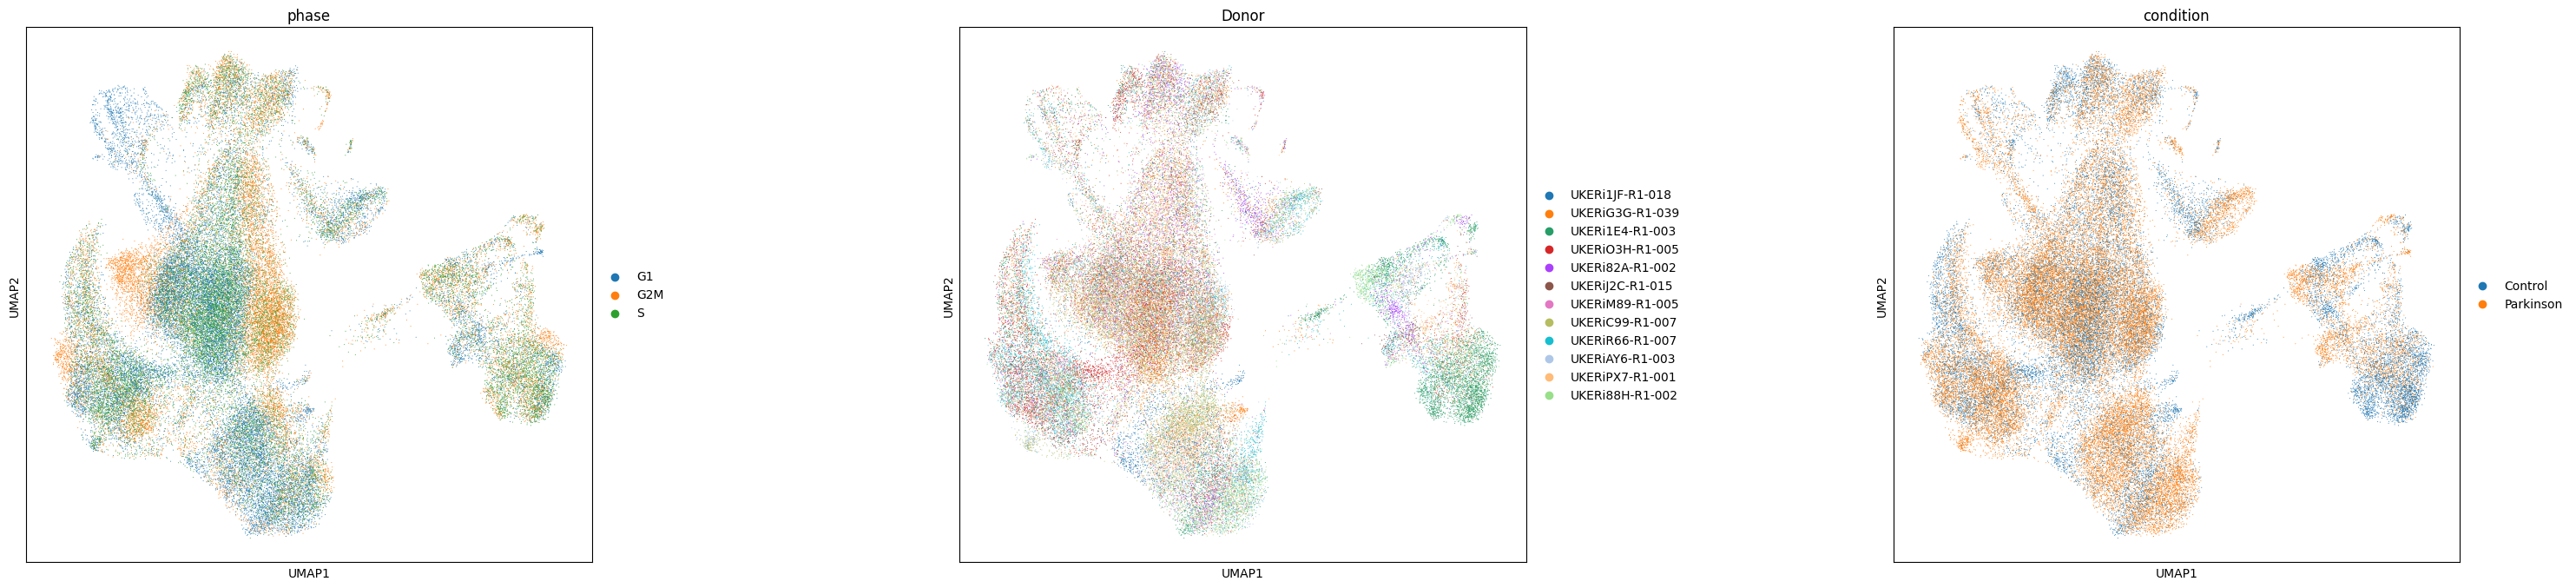

In [40]:
sc.pl.umap(adata, color=['phase', 'Donor', label_key], ncols=3, wspace = 0.5)

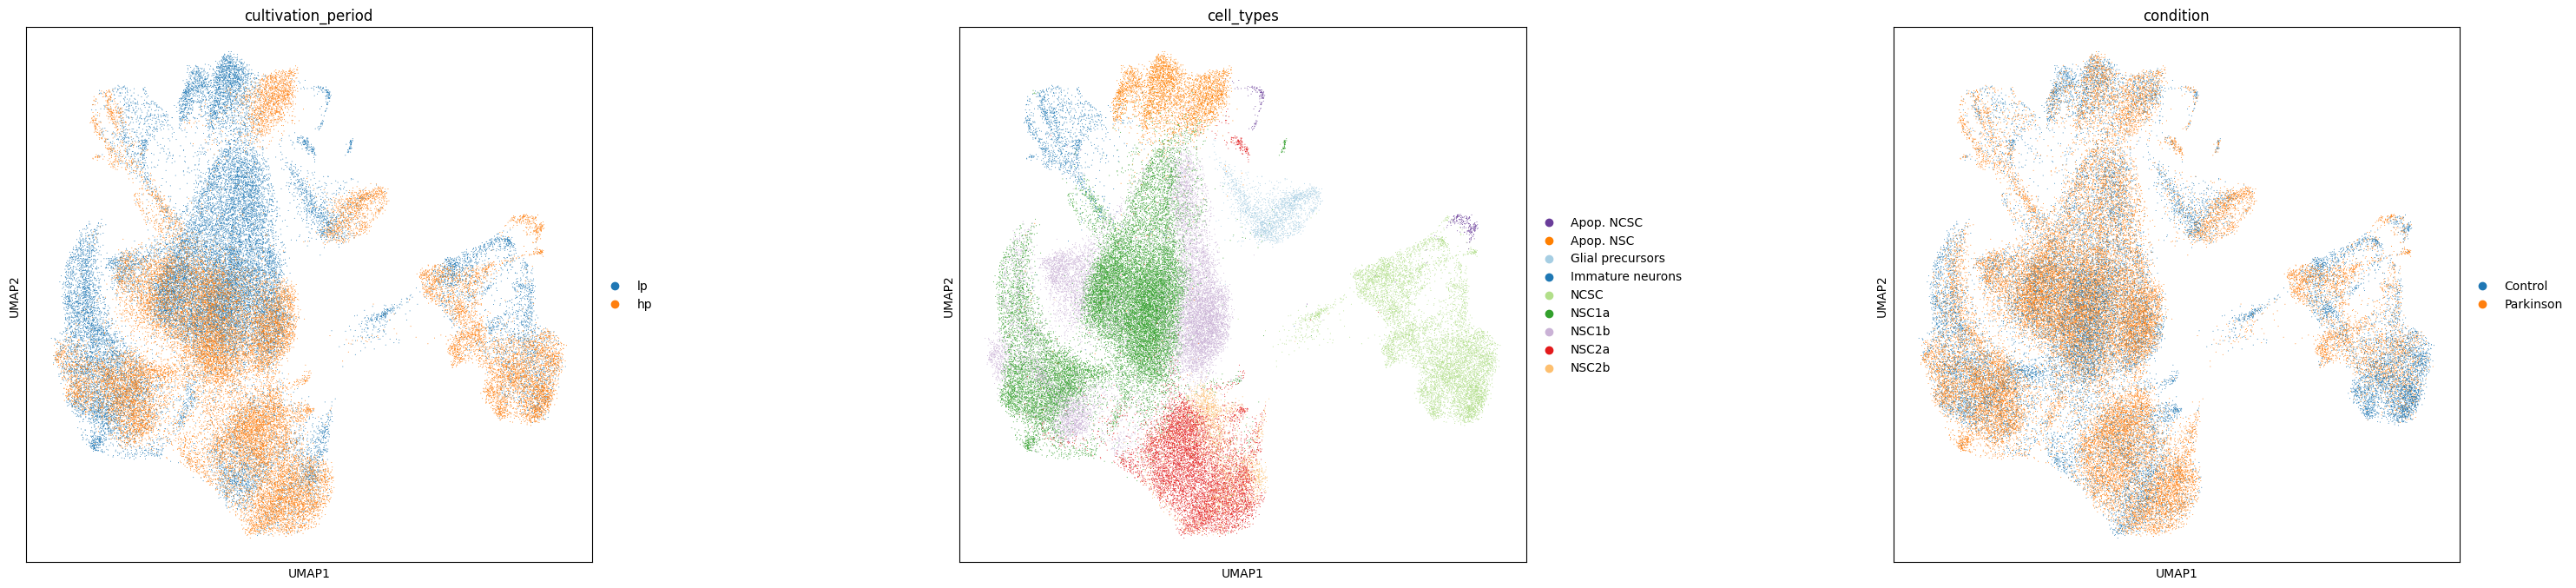

In [41]:
sc.pl.umap(adata, color=['cultivation_period', 'cell_types' , label_key], ncols=3, wspace = 0.5)

In [43]:
adata.write(adata_output)

In [45]:
#model_scanvi.save('NPCs_merge/processed_data/model_scanvi_noCC', save_anndata=True)

In [46]:
#model_scvi = SCVI.load(model_dir)

## Cell death analysis

In [44]:
cell_death_markers = dict()
cell_death_markers['Ferroptosis_pos'] = ['VDAC2', 'VDAC3', 'NRAS', 'KRAS', 'NOX1', 'NOX4', 'NOX5', 'TFRC', 'TP53', 'CARS', 'ACSL4']
cell_death_markers['Ferroptosis_neg'] = ['GPX4', 'SLC7A11', 'HSPB1', 'NFE2L2']
cell_death_markers['Apoptosis_pos'] = ['TP53', 'BAX', 'BAK1'] #other pro apoptotic BCL2 family members
cell_death_markers['Apoptosis_neg'] = ['BCL2', 'BCL2L1', 'MCL1'] #other anti apoptotic BCL2 family members
cell_death_markers['Necroptosis_pos'] = ['RIPK1', 'RIPK3', 'MLKL']
cell_death_markers['Autophagy_pos'] = ['ATG5', 'ATG7', 'BECN1'] #other ATG family proteins
cell_death_markers['Pathanatos_pos'] = ['AIFM1', 'PARP1']

In [ ]:
for cd_type in cell_death_markers:
    if len(set(cell_death_markers[cd_type]).intersection(set(adata.var_names))) < 2:
        print(f'{cd_type} score cannot be calculated as there are insufficient markers in the dataset')
    else:
        sc.tl.score_genes(adata, cell_death_markers[cd_type], score_name=cd_type+'_corr', use_raw=True)
        
        sc.pl.umap(adata, color=cd_type+'_corr', size=10, vmin=0, vmax="p99", sort_order=False, frameon=False, cmap="Reds")
        sc.pl.violin(adata, cd_type+'_corr', groupby='cell_types')

# Summary plots

In [46]:
adata.uns['neighbors'] = adata.uns['neighbors_CC']
adata.obsp['distances'] = adata.obsp['distances_CC']
adata.obsp['connectivities'] = adata.obsp['connectivities_CC']
adata.obsm['X_umap'] = adata.obsm['X_umap_CC']

In [47]:
adata.obs['Donor'] = adata.obs['Donor'].cat.reorder_categories(['UKERi1JF-R1-018', 'UKERiG3G-R1-039', 'UKERi1E4-R1-003', 'UKERiO3H-R1-005', 
                                                  'UKERi82A-R1-002', 'UKERiJ2C-R1-015', 'UKERiM89-R1-005', 'UKERiC99-R1-007', 
                                                  'UKERiR66-R1-007', 'UKERiAY6-R1-003', 'UKERiPX7-R1-001', 'UKERi88H-R1-002'])

In [48]:
adata.obs['cell_types'].cat.categories

Index(['Apop. NCSC', 'Apop. NSC', 'Glial precursors', 'Immature neurons',
       'NCSC', 'NSC1a', 'NSC1b', 'NSC2a', 'NSC2b'],
      dtype='object')

In [49]:
col6 = ['#6a3d9a', #'Apop. NCSC'
'#ff7f00',#'Apop. NSC'
'#a6cee3',#'Glial precursors'
'#1f78b4',#'Immature neurons'
'#b2df8a',#'NCSC'
'#33a02c', #NSC1a
'#cab2d6', #NSC1b
'#e31a1c', #NSC2a
'#fdbf6f', #NSC2b
'#cab2d6'
]

In [50]:
adata.uns['cell_types_colors'] = col6

In [51]:
sc.set_figure_params(scanpy=True, dpi_save=300, figsize=(8,8), vector_friendly=True, format='svg',  transparent=True)

In [ ]:
sc.pl.umap(adata, color='cell_types', size=30, title="", frameon=False, save = '_CC_clustering.svg')

In [53]:
parameter_visualization = ['cell_types', 'cultivation_period', 'Donor', 
                           'condition', 'lane', 'age', 
                           'gender', 'phase', 'years_of_illness',
                           'total_counts', 'pct_counts_mt', 'pct_counts_ribo',
                           'deltaHY', 'deltaUPDRS', 'deltaDOPA']


In [ ]:
sc.pl.umap(adata, size=30, color=parameter_visualization, ncols=3, use_raw=True, sort_order=False, frameon=False, cmap="Reds", save='_CC_summary_plots.svg')

In [ ]:
sc.pl.umap(adata, size=30, color=parameter_visualization, ncols=3, use_raw=True, sort_order=False, frameon=False, save='_CC_summary_plots_othercolors.svg')

In [ ]:
alpha=0.5

sc.pl.umap(adata, color='cell_types', size=30, save='_CC_cell_types.svg', title="", frameon=False)
sc.pl.umap(adata, color='Donor', size=30, save='_CC_Donor.svg', title="", frameon=False, alpha=alpha)
sc.pl.umap(adata, color='condition', size=30, save='_CC_condition.svg', title="", frameon=False, alpha=alpha)
sc.pl.umap(adata, color='phase', size=30, save='_CC_phase.svg', title="", frameon=False, alpha=alpha)
sc.pl.umap(adata, color='age', size=30, save='_CC_age.svg', title="", frameon=False, alpha=alpha)
sc.pl.umap(adata, color='gender', size=30, save='_CC_gender.svg', title="", frameon=False, alpha=alpha)
sc.pl.umap(adata, color='years_of_illness', size=30, save='_CC_years_of_illness.svg', title="", frameon=False)
sc.pl.umap(adata, color='deltaHY', size=30, save='_CC_deltaHY.svg', title="", frameon=False)
sc.pl.umap(adata, color='deltaUPDRS', size=30, save='_CC_deltaUPDRS.svg', title="", frameon=False)
sc.pl.umap(adata, color='deltaADL', size=30, save='_CC_deltaADL.svg', title="", frameon=False)
sc.pl.umap(adata, color='deltaDOPA', size=30, save='_CC_deltaDOPA.svg', title="", frameon=False)
sc.pl.umap(adata, color='total_counts', size=30, save='_CC_total_counts.svg', title="", frameon=False)
sc.pl.umap(adata, color='pct_counts_mt', size=30, save='_CC_pct_counts_mt.svg', title="", frameon=False)
sc.pl.umap(adata, color='pct_counts_ribo', size=30, save='_CC_pct_counts_ribo.svg', title="", frameon=False)


# Marker plots

In [57]:
genes =['SOX2', 'FABP7', 'DAAM1', 'PTCH1',
        'SOX2', 'SHH','FOXA2','HES1',
        'SOX10','S100B', 'DCX','MAP2',
        'BCL2','BAX','LUM','LGALS1',
        'CENPF','AURKB','CDC20']

In [58]:
# Abbreviate the cell annotations for plots
adata.obs['cell_types_abbrev'] = ['Glial prec.' if ct.startswith('Glial') else 'Imm. Neurons' if ct.startswith('Immature') else ct for ct in adata.obs['cell_types']]
adata.obs['cell_types_abbrev'] = adata.obs['cell_types_abbrev'].astype('category')

In [59]:
adata.obs['cell_types_abbrev'].cat.categories

Index(['Apop. NCSC', 'Apop. NSC', 'Glial prec.', 'Imm. Neurons', 'NCSC',
       'NSC1a', 'NSC1b', 'NSC2a', 'NSC2b'],
      dtype='object')

In [60]:
col6 = ['#6a3d9a', #'Apop. NCSC'
'#ff7f00',#'Apop. NSC'
'#a6cee3',#'Glial precursors'
'#1f78b4',#'Immature neurons'
'#b2df8a',#'NCSC'
'#33a02c', #NSC1a
'#cab2d6', #NSC1b
'#e31a1c', #NSC2a
'#fdbf6f', #NSC2b
'#cab2d6'
]

adata.uns['cell_types_abbrev_colors'] = col6


In [ ]:
sc.pl.umap(adata, size=30, color=genes+["cell_types_abbrev"], ncols=4, title=genes+[''], use_raw=False, vmin=0, vmax="p99", sort_order=False, frameon=False, cmap="Reds", save='_CC_marker_genes.svg')

# Summary plots noCC

In [62]:
adata.uns['neighbors'] = adata.uns['neighbors_noCC']
adata.obsp['distances'] = adata.obsp['distances_noCC']
adata.obsp['connectivities'] = adata.obsp['connectivities_noCC']
adata.obsm['X_umap'] = adata.obsm['X_umap_noCC']

In [ ]:
sc.pl.umap(adata, color='cell_types', size=30, title="", frameon=False, save = '_noCC_clustering.svg')

In [ ]:
sc.pl.umap(adata, size=30, color=parameter_visualization, ncols=3, use_raw=True, sort_order=False, frameon=False, cmap="Reds", save='_noCC_summary_plots.svg')

In [ ]:
sc.pl.umap(adata, size=30, color=parameter_visualization, ncols=3, use_raw=True, sort_order=False, frameon=False, save='_noCC_summary_plots_othercolors.svg')

In [ ]:
alpha=0.5

sc.pl.umap(adata, color='cell_types', size=30, save='_noCC_cell_types.svg', title="", frameon=False)
sc.pl.umap(adata, color='Donor', size=30, save='_noCC_Donor.svg', title="", frameon=False, alpha=alpha)
sc.pl.umap(adata, color='condition', size=30, save='_noCC_condition.svg', title="", frameon=False, alpha=alpha)
sc.pl.umap(adata, color='phase', size=30, save='_noCC_phase.svg', title="", frameon=False, alpha=alpha)
sc.pl.umap(adata, color='age', size=30, save='_noCC_age.svg', title="", frameon=False, alpha=alpha)
sc.pl.umap(adata, color='gender', size=30, save='_noCC_gender.svg', title="", frameon=False, alpha=alpha)
sc.pl.umap(adata, color='years_of_illness', size=30, save='_noCC_years_of_illness.svg', title="", frameon=False)
sc.pl.umap(adata, color='deltaHY', size=30, save='_noCC_deltaHY.svg', title="", frameon=False)
sc.pl.umap(adata, color='deltaUPDRS', size=30, save='_noCC_deltaUPDRS.svg', title="", frameon=False)
sc.pl.umap(adata, color='deltaADL', size=30, save='_noCC_deltaADL.svg', title="", frameon=False)
sc.pl.umap(adata, color='deltaDOPA', size=30, save='_noCC_deltaDOPA.svg', title="", frameon=False)
sc.pl.umap(adata, color='total_counts', size=30, save='_noCC_total_counts.svg', title="", frameon=False)
sc.pl.umap(adata, color='pct_counts_mt', size=30, save='_noCC_pct_counts_mt.svg', title="", frameon=False)
sc.pl.umap(adata, color='pct_counts_ribo', size=30, save='_noCC_pct_counts_ribo.svg', title="", frameon=False)


# Marker plots noCC

In [ ]:
sc.pl.umap(adata, size=30, color=genes+["cell_types_abbrev"], ncols=4, title=genes+[''], use_raw=False, vmin=0, vmax="p99", sort_order=False, frameon=False, cmap="Reds", save='_noCC_marker_genes.svg')

# Write data to file

In [68]:
adata.uns['neighbors'] = adata.uns['neighbors_CC']
adata.obsp['distances'] = adata.obsp['distances_CC']
adata.obsp['connectivities'] = adata.obsp['connectivities_CC']
adata.obsm['X_umap'] = adata.obsm['X_umap_CC']

In [69]:
# Remove rank_genes_groups output, which is tough to save to file
ad_uns_keys = list(adata.uns.keys())

for i in ad_uns_keys:
    if i.startswith('rank_'):
        print(f'removing {i}')
        del adata.uns[i]

In [70]:
# Remove rank_genes_groups output, which is tough to save to file
ad_uns_keys = list(adata.uns.keys())

for i in ad_uns_keys:
    if i.startswith('leiden_'):
        print(f'removing {i}')
        del adata.uns[i]

In [71]:
# Remove rank_genes_groups output, which is tough to save to file
ad_uns_keys = list(adata.uns.keys())

for i in ad_uns_keys:
    if i.startswith('dendrogram_leiden'):
        print(f'removing {i}')
        del adata.uns[i]

In [72]:
# Remove unnecessary obs
ad_obs_keys = list(adata.obs.keys())

for i in ad_obs_keys:
    if i.startswith('leiden_'):
        print(f'removing {i}')
        del adata.obs[i]

In [73]:
adata.write(adata_output)